**IRIS**

**Общая информация**

**Срок сдачи:** 20 марта 2019, 06:00 <br\>
**Штраф за опоздание:** -1 балл после 06:00 20 марта, -2 балла после 06:00 27 марта, -3 балла после 06:00 3 апреля

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack скинуть ссылку в личный чат @alkhamush
Пример ссылки:
https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb 


Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pylab
from sklearn.datasets import fetch_openml

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
import scipy as sp
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [4]:
#%%pycodestyle


class MyKNeighborsClassifier (NeighborsBase, KNeighborsMixin,
                              SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors=5, p=2, metric='minkowski',
                 algorithm='brute', leaf_size=30, metric_params='None',
                 n_jobs='None', weights='uniform'):
        self.n_neighbors = n_neighbors
        self.pow = p
        self.metric = metric
        self.algorithm = algorithm
        self.leaf_size = leaf_size
        self.metric_params = metric_params
        self.weights = weights
        self.n_jobs = n_jobs

    def fit(self, X, y):
        self.data = X
        self.cluster = len(np.unique(y))
        self.cl_name = np.unique(y)
        self.targ = y
        self.length = len(X)
        pass

    def clusters_weight_for_every_point_kd(self, distance, index):
        '''
        counts the weight of point classes obtained with kd_tree
        the weight of the point class is inversely proportional to the
        distance to the point
        '''
        weight = np.zeros(shape=(self.cluster))
        proba = np.zeros(shape=len(distance), dtype=type(self.cl_name[0]))

        for t in range(len(distance)):
            for i in range(self.n_neighbors):
                weight[self.cl_name == self.targ[int(index[t, i])]] += 1
            proba[t] = self.cl_name[weight.argmax()]
            weight[::1] = 0
        res = np.array(proba)
        return res

    def clusters_weight_for_every_point_brute(self, X):
        '''
        counts the distance from each point from X to each point from
        self.data, selects the closest n_neighbors and counts the weight
        of their class the weight of the point class is inversely
        proportional to the distance to the point
        '''
        weight = np.zeros(shape=(len(X), self.cluster))
        distance = cdist(X, self.data)
        arr_k = np.zeros(shape=(len(X), self.n_neighbors))

        for i in range(len(X)):
            arr_k[i] = np.argsort(distance[i])[:self.n_neighbors]

        for i in range(len(X)):
            for t in range(self.n_neighbors):
                weight[i, self.cl_name == self.targ[int(arr_k[i, t])]] += 1
        return weight

    def predict(self, X):
        '''
        predicts a class of points from X based on self.data and self.targ
        '''
        proba = np.zeros(shape=(len(X)), dtype=type(self.cl_name[0]))

        if (self.algorithm == 'brute'):
            tmp = self.clusters_weight_for_every_point_brute(X)
            for i in range(len(X)):
                proba[i] = self.cl_name[tmp[i].argmax()]
            self.proba = np.array(proba)

        elif (self.algorithm == 'kd_tree'):
            tree = KDTree(self.data, leaf_size=40)
            dist, ind = tree.query(X, k=self.n_neighbors)
            self.proba = self.clusters_weight_for_every_point_kd(dist, ind)
        return self.proba

    def predict_proba(self, X):
        '''
        predicts the probability of belonging to each class
        for each point of X based on self.data and self.targ
        '''
        self.pred_proba = np.zeros(shape=(len(X), self.cluster))

        if (self.algorithm == 'brute'):
            count = self.count_of_points_for_clusters_brute(X)
            for i in range(len(X)):
                for j in range(self.cluster):
                    self.pred_proba[i, j] = count[i, j] / self.n_neighbors

        elif (self.algorithm == 'kd_tree'):
            tree = KDTree(self.data, leaf_size=40)
            dist, ind = tree.query(X, k=self.n_neighbors)
            count = self.count_of_points_for_clusters_kd_tree(len(X), ind)
            for i in range(len(X)):
                for j in range(self.cluster):
                    self.pred_proba[i, j] = count[i, j] / self.n_neighbors
        return self.pred_proba

    def count_of_points_for_clusters_brute(self, X):
        '''
        counts the distance from each point from X to each point
        from self.data, finds among them the n_neighbors of the best ones
        and counts the number of points of each class among
        '''
        count = np.zeros(shape=(len(X), self.cluster))
        distance = cdist(X, my_clf.data)
        arr_k = np.zeros(shape=(len(X), self.n_neighbors))

        for i in range(len(X)):
            arr_k = np.argsort(distance[i])[:self.n_neighbors]
            for j in range(self.n_neighbors):
                count[i, self.cl_name == self.targ[int(arr_k[j])]] += 1
        return count

    def count_of_points_for_clusters_kd_tree(self, len_test, ind):
        '''
        counts the number of points of each class among those obtained
        with kd_tree
        '''
        count = np.zeros(shape=(len_test, self.cluster))
        for i in range(len_test):
            for j in range(self.n_neighbors):
                count[i, self.cl_name == self.targ[int(ind[i, j])]] += 1
        return count

    def score(self, X, y):
        '''
        calculate accuracy of prediction
        '''
        right_choice = 0
        for i in range(len(y)):
            if (y[i] == self.proba[i]):
                right_choice += 1
        return right_choice / len(y)

In [5]:
iris = datasets.load_iris()
df = np.array(iris)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [7]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 1.49 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 993 µs


In [10]:
%time clf.predict(X_test)

Wall time: 3.47 ms


array([0, 2, 2, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 2])

In [11]:
%time my_clf.predict(X_test)

Wall time: 2.48 ms


array([0, 2, 2, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 2])

In [12]:
%time clf.predict_proba(X_test)

Wall time: 1.49 ms


array([[1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ]])

In [13]:
%time my_clf.predict_proba(X_test)

Wall time: 1.49 ms


array([[1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ]])

In [14]:
clf.score(X_test, y_test)

0.9333333333333333

In [15]:
my_clf.score(X_test, y_test)

0.9333333333333333

Задание 3

The best mean score is for n_neighbors =  17


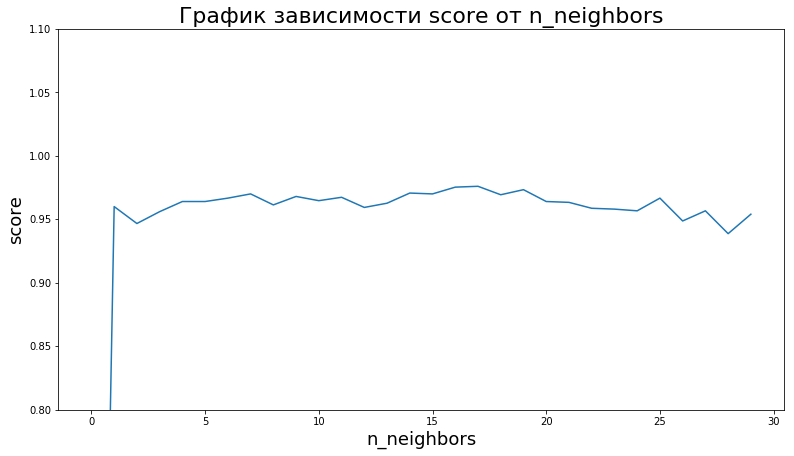

In [22]:
iris = datasets.load_iris()
df = np.array(iris)
grafic = np.zeros(shape=30)
x = np.zeros(shape=30)

for i in (range(29)):
    sum_score = 0
    for j in range(100):
        X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
        my_clf = MyKNeighborsClassifier(n_neighbors=i+1)
        my_clf.fit(X_train, y_train)
        my_clf.predict(X_test)
        sum_score += my_clf.score(X_test, y_test)
    x[i+1] = i + 1
    grafic[i+1] = sum_score / 100
    
main_n_neighbors = grafic.argmax()
print("The best mean score is for n_neighbors = ", main_n_neighbors)
fig = pylab.figure(figsize = (13, 7))
ax = fig.add_subplot(111) 
ax.plot(grafic)
pylab.ylim(0.8, 1.1)
pylab.xlabel('n_neighbors', size=18)
pylab.ylabel('score', size=18)
ax.set_title('График зависимости score от n_neighbors', size=22)

pylab.show()

**MNIST**

In [50]:
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [51]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [53]:
%time clf.fit(X_train, y_train)

Wall time: 51.9 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [54]:
%time my_clf.fit(X_train, y_train)

Wall time: 144 ms


In [55]:
%time clf.predict(X_test)

Wall time: 2min 28s


array(['5', '1', '7', '9', '9', '0', '9', '9', '1', '1', '0', '0', '6',
       '8', '1', '1', '8', '3', '3', '0', '1', '6', '3', '3', '2', '4',
       '0', '6', '0', '9', '2', '7', '8', '9', '1', '7', '8', '8', '9',
       '8', '3', '2', '7', '4', '3', '8', '2', '1', '4', '8', '5', '1',
       '7', '6', '4', '5', '1', '4', '0', '2', '1', '9', '4', '4', '9',
       '2', '3', '8', '6', '7', '6', '5', '5', '6', '2', '6', '9', '6',
       '1', '0', '7', '2', '6', '6', '8', '0', '9', '0', '9', '4', '2',
       '3', '2', '5', '3', '1', '6', '1', '7', '4', '0', '5', '5', '5',
       '3', '4', '5', '8', '2', '3', '9', '8', '4', '1', '0', '9', '6',
       '9', '1', '7', '0', '1', '7', '0', '5', '0', '6', '6', '7', '4',
       '6', '0', '3', '7', '6', '5', '6', '1', '5', '9', '6', '0', '5',
       '0', '0', '2', '4', '8', '3', '0', '9', '7', '1', '0', '2', '6',
       '3', '8', '6', '2', '1', '9', '6', '8', '0', '7', '4', '1', '9',
       '6', '7', '1', '7', '8', '5', '2', '3', '9', '3', '3', '9

In [56]:
%time my_clf.predict(X_test)

Wall time: 1min 46s


array(['5', '1', '7', '9', '9', '0', '9', '9', '1', '1', '0', '0', '6',
       '8', '1', '1', '8', '3', '3', '0', '1', '6', '3', '3', '2', '4',
       '0', '6', '0', '9', '2', '7', '8', '9', '1', '7', '8', '8', '9',
       '8', '3', '2', '7', '4', '3', '8', '2', '1', '4', '8', '5', '1',
       '7', '6', '4', '5', '1', '4', '0', '2', '1', '9', '4', '4', '9',
       '2', '3', '8', '6', '7', '6', '5', '5', '6', '2', '6', '9', '6',
       '1', '0', '7', '2', '6', '6', '8', '0', '9', '0', '9', '4', '2',
       '3', '2', '5', '3', '1', '6', '1', '7', '4', '0', '5', '5', '5',
       '3', '4', '5', '8', '2', '3', '9', '8', '4', '1', '0', '9', '6',
       '9', '1', '7', '0', '1', '7', '0', '5', '0', '6', '6', '7', '4',
       '6', '0', '3', '7', '6', '5', '6', '1', '5', '9', '6', '0', '5',
       '0', '0', '2', '4', '8', '3', '0', '9', '7', '1', '0', '2', '6',
       '3', '8', '6', '2', '1', '9', '6', '8', '0', '7', '4', '1', '9',
       '6', '7', '1', '7', '8', '5', '2', '3', '9', '3', '3', '9

In [57]:
%time clf.predict_proba(X_test)

Wall time: 2min 19s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
%time my_clf.predict_proba(X_test)

Wall time: 1min 44s


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [59]:
clf.score(X_test, y_test)

0.9614285714285714

In [60]:
my_clf.score(X_test, y_test)

0.9614285714285714

Задание 4

In [61]:
clf = KNeighborsClassifier(n_neighbors=17, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=17, algorithm='kd_tree')

In [62]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [63]:
%time clf.fit(X_train, y_train)

Wall time: 53.9 s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=17, p=2,
           weights='uniform')

In [64]:
%time my_clf.fit(X_train, y_train)

Wall time: 173 ms


In [65]:
%time clf.predict(X_test)

Wall time: 2min 19s


array(['2', '1', '7', '0', '7', '1', '1', '6', '1', '7', '8', '3', '6',
       '1', '5', '0', '4', '7', '5', '0', '3', '6', '9', '0', '7', '7',
       '6', '4', '5', '7', '6', '7', '7', '3', '1', '4', '4', '1', '4',
       '7', '0', '5', '8', '1', '2', '4', '6', '4', '2', '3', '2', '3',
       '3', '4', '3', '9', '1', '2', '6', '9', '1', '6', '7', '6', '8',
       '2', '9', '8', '2', '6', '7', '1', '8', '0', '8', '2', '7', '7',
       '0', '2', '6', '2', '6', '0', '3', '3', '1', '8', '1', '9', '4',
       '4', '6', '2', '1', '3', '2', '1', '6', '1', '6', '1', '6', '9',
       '7', '8', '7', '8', '1', '2', '0', '5', '7', '8', '0', '7', '1',
       '1', '7', '3', '9', '2', '0', '8', '9', '7', '0', '4', '2', '3',
       '8', '5', '2', '8', '6', '5', '5', '4', '1', '7', '7', '5', '9',
       '7', '5', '4', '2', '1', '0', '2', '0', '0', '8', '0', '5', '9',
       '5', '5', '3', '4', '7', '9', '7', '9', '1', '2', '9', '4', '7',
       '2', '9', '0', '6', '2', '4', '1', '3', '8', '6', '6', '8

In [66]:
%time my_clf.predict(X_test)

Wall time: 2min 48s


array(['2', '1', '7', '0', '7', '1', '1', '6', '1', '7', '8', '3', '6',
       '1', '5', '0', '4', '7', '5', '0', '3', '6', '9', '0', '7', '7',
       '6', '4', '5', '7', '6', '7', '7', '3', '1', '4', '4', '1', '4',
       '7', '0', '5', '8', '1', '2', '4', '6', '4', '2', '3', '2', '3',
       '3', '4', '3', '9', '1', '2', '6', '9', '1', '6', '7', '6', '8',
       '2', '9', '8', '2', '6', '7', '1', '8', '0', '8', '2', '7', '7',
       '0', '2', '6', '2', '6', '0', '3', '3', '1', '8', '1', '9', '4',
       '4', '6', '2', '1', '3', '2', '1', '6', '1', '6', '1', '6', '9',
       '7', '8', '7', '8', '1', '2', '0', '5', '7', '8', '0', '7', '1',
       '1', '7', '3', '9', '2', '0', '8', '9', '7', '0', '4', '2', '3',
       '8', '5', '2', '8', '6', '5', '5', '4', '1', '7', '7', '5', '9',
       '7', '5', '4', '2', '1', '0', '2', '0', '0', '8', '0', '5', '9',
       '5', '5', '3', '4', '7', '9', '7', '9', '1', '2', '9', '4', '7',
       '2', '9', '0', '6', '2', '4', '1', '3', '8', '6', '6', '8

In [67]:
%time clf.predict_proba(X_test)

Wall time: 2min 22s


array([[0.        , 0.        , 0.94117647, ..., 0.05882353, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.82352941, 0.        ,
        0.05882353],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [68]:
%time my_clf.predict_proba(X_test)

Wall time: 2min 57s


array([[0.        , 0.        , 0.94117647, ..., 0.05882353, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.82352941, 0.        ,
        0.05882353],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [69]:
clf.score(X_test, y_test)

0.9685714285714285

In [70]:
my_clf.score(X_test, y_test)

0.9685714285714285

Задание 5

In [40]:
# seaborn - высокоуровневая библиотека python для создания статических графиков, отличается от matplotlib 
#           тем, что имеет множество параметров, установленных в matplotlib по умолчанию, чем значительно 
#           упрощает работу со сложными моделями

# matplotlib - высокоуровневая библиотека python, позволяющая легко строить множество различных 2D графиков, для
#           быстрых наглядных оценок моделейб, так же имеет процедурный интерфейс pylab.

# train_test_split - функция из библиотеки sklearn (модуль sklearn.cross_validation) позволяющая разбить 
#           входные данные на обучающую и тестовую выборку (test_size = размер тестов / размер всех данных).

# Pipeline%load_ext e (from sklearn.pipeline import Pipeline) - импортирует составной классификатор IPyhon
#           из предобработчика данных Pipeline по имени e

# StandardScaler (from sklearn.preprocessing import StandardScaler) - класс python, позволяющий стандартизировать 
#           данные с помощью стандартного и среднего отклонения, путём удаления среднего и масштабирования
#           до единичной дисперсии. Это необходимо для многих моделей машинного обучения
#           так как многие модели показывают себя гораздо лучше на стандартных нормально распределённых данных.

# ClassifierMixin - класс python, используемый для вычисления среднего значения точности на данных и метках.
#           главный метод: score реализующий жёсткую метрику в задачах классификации с несколькими метками.

# NeighborsBase - класс python, используемый для проверки корректности параметоров и поддержки таких методов как
#           поиск K ближайших соседей и поиска соседей в заданном радиусе. Имеет параметры:  n_neighbors - количество соседей,  
#           radius - радиус в котором ищутся соседи, algorithm - вид алгоритма (например KDTree, BallTree, Brute Force, auto),
#           leaf_size количество точек для алгоритмов KDTree и BallTree, metric - вид метрики, p - степень, 
#           metric_params - дополнительные параметры метрики, n_jobs - распараллеливание процессов.

# KNeighborsMixin - класс python реализующий алгоритм поиска K ближайших соседей с основным методом 
#           def kneighbors(self, X=None, n_neighbors=None, return_distance=True) - реализующим сам поиск.
#           Все методы: _kneighbors_reduce_func, kneighbors, kneighbors_graph.

# SupervisedIntegerMixin - класс python с единственным методом fit(self, X, y) - заполняет модель используя X, 
#           как тренировочные данные, a y как их целевые значения (например принадлежность к кластеру), так же 
#           проверяет корректность входных данных и выводит поясняющие сообщения об ошибках.